In [1]:
import sys
import time
from pathlib import Path

from openeye import oechem, oedepict
import oenotebook as oenb

import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm

assert oechem.OEChemIsLicensed(), "OpenEye License not found!"

In [2]:
sys.path.append(str(Path().resolve().parent))

In [3]:
from torsion.utils.process_sd_data import dump_sd_data, get_sd_data
from torsion.utils.plotting import plot_dihedral, oenb_draw_dihedral, nb_gallery, plot_energy_profile, grab_plot_as_png
from torsion.inchi_keys import get_specific_dihedral_inchi_key
from torsion.model import get_sf_elements

In [4]:
%matplotlib inline

Say you have $N$ torsion fragments with each fragment having one "torsion of interest". We will assume you have generated the following data in SD files:

1. MM Conformers: $N$ sets of 24 conformers, for each torsion fragment, where the torsion of interest has been rotated by 15 degrees. The torsion angle of each conformer should be provided as an SD property `TORSION_ANGLE`.
2. QM Conformers: The $N$ sets of 24 QM optimized conformers (using a method/basis set of your choice) corresponding to each of the MM conformers. The optimized QM energy for each conformer should be provided as an SD property `Energy`.

In all these files, the torsion atoms of interest should be listed as a space-separated string of 4 integers under the SD property `TORSION_ATOMS_FRAGMENT`.

In [5]:
frags    = "../data/TorsionNet500.sdf"
mm_confs = "../data/TorsionNet500_mm_opt_geometries.sdf"
qm_confs = "../data/TorsionNet500_qm_opt_geometries.sdf"

ANGLE_TAG  = "TORSION_ANGLE"
ENERGY_TAG = "Energy"

### Read in the torsion fragments and the corresponding MM and QM conformers

In [6]:
ifs = oechem.oemolistream()
if not ifs.open(frags):
    raise ValueError(f"Unable to open {frags} for reading.")

frag_name_list = []
frag_list = []
start_time = time.time()
for mol_no, mol in enumerate(ifs.GetOEGraphMols()):
    if (mol_no+1) % 100 == 0:
        print(f"Read torsion fragment no. {mol_no+1:6d}", end='\r', flush=True)
    frag_name = get_specific_dihedral_inchi_key(mol)
    frag_name_list.append(frag_name)
    frag_list.append(oechem.OEGraphMol(mol))
print(f"\nin {time.time() - start_time:.0f}s")    

Read torsion fragment no.    500
in 1s


In [7]:
mm_ifs = oechem.oemolistream()
if not mm_ifs.open(mm_confs):
    raise ValueError(f"Unable to open {mm_confs} for reading.")

mm_conformer_list = []
mm_conformer_name_list = []
start_time = time.time()
for mol_no, mol in enumerate(mm_ifs.GetOEGraphMols()):
    if (mol_no+1) % 1000 == 0:
        print(f"Read MM conformer no. {mol_no+1:6d}", end='\r', flush=True)
    mm_conformer_name = get_specific_dihedral_inchi_key(mol) + '-' + str(int(get_sd_data(mol, 'TORSION_ANGLE')) % 360)
    mm_conformer_name_list.append(mm_conformer_name)
    mm_conformer_list.append(oechem.OEGraphMol(mol))
print(f"\nin {time.time() - start_time:.0f}s")   
mm_conformers = np.array_split(mm_conformer_list, len(mm_conformer_list)/24)

Read MM conformer no.  12000
in 15s


In [8]:
qm_ifs = oechem.oemolistream()
if not qm_ifs.open(qm_confs):
    raise ValueError(f"Unable to open {qm_confs} for reading.")

qm_conformer_name_list = []
start_time = time.time()
angle = []
qm_energy = []
for mol_no, mol in enumerate(qm_ifs.GetOEGraphMols()):
    if (mol_no+1) % 1000 == 0:
        print(f"Read QM conformer no. {mol_no+1:6d}", end='\r', flush=True)
    qm_conformer_name = get_specific_dihedral_inchi_key(mol) + '-' + str(int(get_sd_data(mol, 'TORSION_ANGLE')) % 360)
    qm_conformer_name_list.append(qm_conformer_name)
    angle.append(float(get_sd_data(mol, ANGLE_TAG)))
    qm_energy.append(float(get_sd_data(mol, ENERGY_TAG)))
print(f"\nin {time.time() - start_time:.0f}s")
qm_energy = np.array(qm_energy).reshape((-1, 24))
qm_energy -= np.expand_dims(qm_energy.min(axis=1), axis=1)
angle = np.array(angle).reshape((-1, 24))

Read QM conformer no.  12000
in 14s


We have 500 torsion fragments. So we have 500 x 24 = 12000 MM and QM conformers.

### Examine QM Data

Let's look at the first 12 fragments and the corresponding QM energy profiles


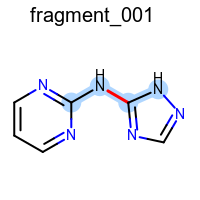
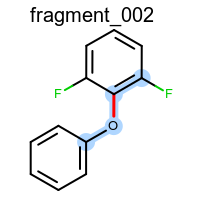
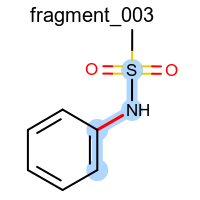
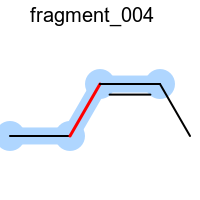
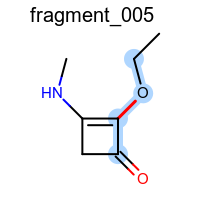
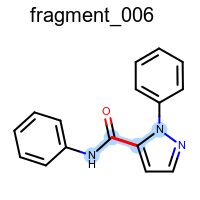
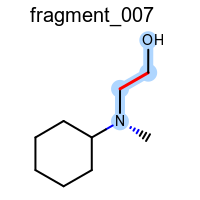
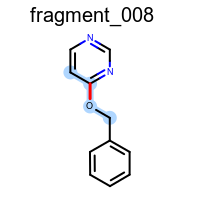
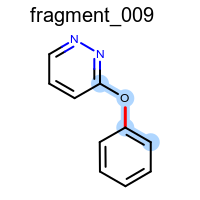
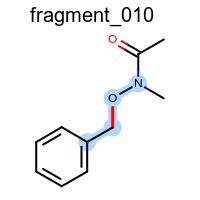
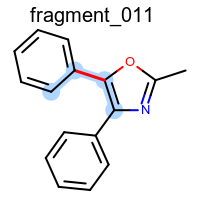
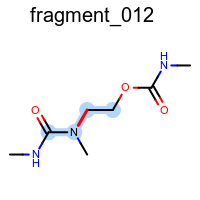

In [9]:
images = [oedepict.OEWriteImageToString("png", plot_dihedral(x)) for x in frag_list[:12]]
nb_gallery(images)


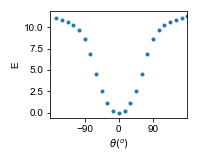
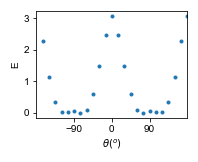
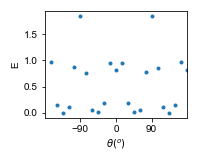
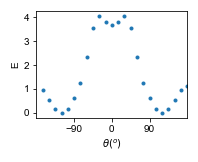
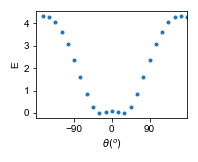
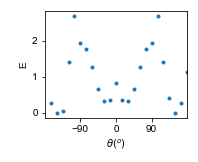
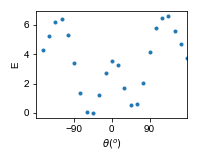
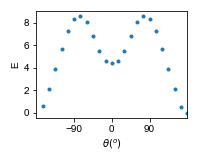
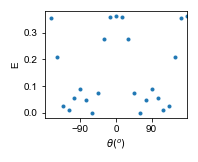
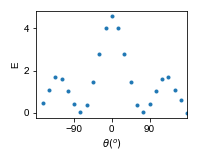
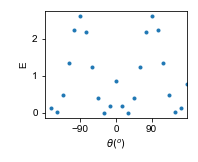
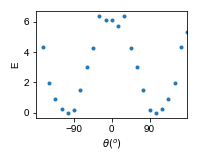

In [10]:
images = [grab_plot_as_png(plot_energy_profile(angle[i], qm_energy[i])) for i in range(12)]
nb_gallery(images)

### Confirm structure match

In the next few cells we will use the unique identifier for the fragment and the torsion of interest (the `specific_dihedral_inchi_key` generated when reading in the MM and QM conformers above) to ensure that the fragments and the torsions of interest in both SD files match.

In [11]:
unique_conformer_name_list = ['-'.join(x.split('-')[:-1]) for x in mm_conformer_name_list]
unique_conformer_name_list = list(dict.fromkeys(unique_conformer_name_list))
unique_conformer_name_list == frag_name_list

True

In [12]:
qm_conformer_name_list == mm_conformer_name_list

True

The two `True` values above confirm that (1) The order of the torsional fragments matches the order of the MM conformers; and (2) the order of the MM conformers matches the order of the QM conformers.

### Split dataset into training and test sets

In [13]:
frag_indices = list(range(len(frag_name_list)))
train_indices, test_indices = train_test_split(frag_indices, test_size=0.2, random_state=12345)

frag_train = [frag_list[i] for i in train_indices]
frag_test  = [frag_list[i] for i in test_indices]

mm_conformers_train = [mm_conformers[i] for i in train_indices]
mm_conformers_test =  [mm_conformers[i] for i in test_indices]

angle_train = angle[train_indices,:]
angle_test  = angle[test_indices, :]

y_train = qm_energy[train_indices,:]
y_test  = qm_energy[test_indices, :]

### Feature Generation

In [14]:
X_train = []
for x in tqdm(mm_conformers_train):
    for y in x:
        X_train.append(get_sf_elements(y))

X_train = np.array(X_train)

100%|██████████| 400/400 [04:38<00:00,  1.44it/s]


In [15]:
X_test = []
for x in tqdm(mm_conformers_test):
    for y in x:
        X_test.append(get_sf_elements(y))

X_test = np.array(X_test)

100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


In [16]:
X_train.shape

(9600, 293)

In [17]:
X_test.shape

(2400, 293)

In [18]:
y_train = y_train.flatten()
y_train.shape

(9600,)

In [19]:
y_test = y_test.flatten()
y_test.shape

(2400,)

We now save these features and the targets to disk

In [20]:
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)